In [1]:
# !pip install pandas matplotlib numpy

In [2]:
import os
from pathlib import Path
from tabulate import tabulate

from plotter import *
from plotter.epochstats import EpochStats
from plotter.plotepochstats import PlotRangeQueryStats, PlotEpochStats, plot_total_data_movement
from plotter.plotselectivities import PlotSelectivities, PlotSelectivitiesRangeQuery
from plotter.utils import vanilla_dirname, rqdc_dirname
from plotter.dataclass import TABLE_DATA

PROJECT_DIR = Path.cwd().parent.parent

['Column Family Name: default, Size: 1907399621 bytes, Files Count: 509', 'Level Stats:', 'Level: 0, Files: 0, Size: 0 bytes', 'Level: 1, Files: 1, Size: 4264730 bytes', 'Level: 2, Files: 4, Size: 15423831 bytes', 'Level: 3, Files: 9, Size: 33412350 bytes', 'Level: 4, Files: 16, Size: 63183267 bytes', 'Level: 5, Files: 35, Size: 130377400 bytes', 'Level: 6, Files: 71, Size: 264435973 bytes', 'Level: 7, Files: 153, Size: 534596038 bytes', 'Level: 8, Files: 220, Size: 861706032 bytes', 'Level: 9, Files: 0, Size: 0 bytes', 'Level: 10, Files: 0, Size: 0 bytes', 'Level: 11, Files: 0, Size: 0 bytes', 'Level: 12, Files: 0, Size: 0 bytes', 'Level: 13, Files: 0, Size: 0 bytes', 'Level: 14, Files: 0, Size: 0 bytes', 'Level: 15, Files: 0, Size: 0 bytes', 'Level: 16, Files: 0, Size: 0 bytes', 'Level: 17, Files: 0, Size: 0 bytes', 'Level: 18, Files: 0, Size: 0 bytes', 'Level: 19, Files: 0, Size: 0 bytes', '', 'RocksDB Statistics:', 'rocksdb.compact.read.bytes: 30746163405', 'rocksdb.compact.write.b

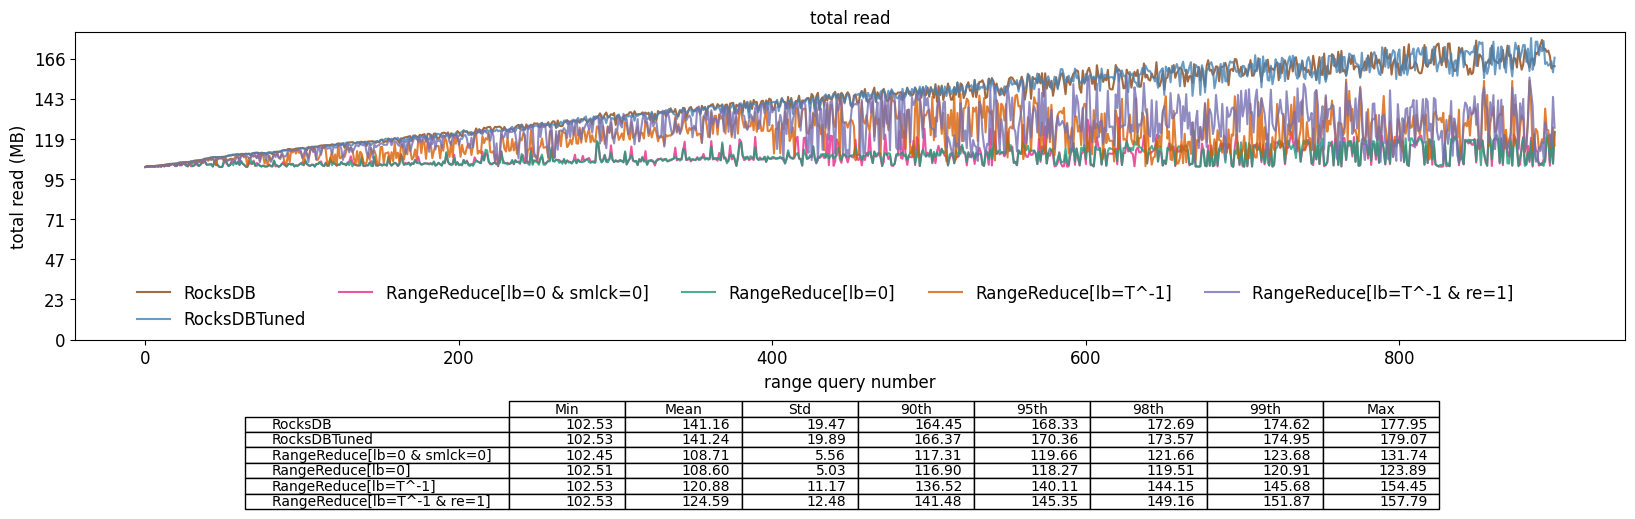

RocksDB 1106.2234891866667
RocksDBTuned 0.006028494016574162
RangeReduce[lb=0 & smlck=0] 0.2864104119745749
RangeReduce[lb=0] 0.2424409358218535
RangeReduce[lb=T^-1] -0.04707593362770784
RangeReduce[lb=T^-1 & re=1] -0.02090955695219258


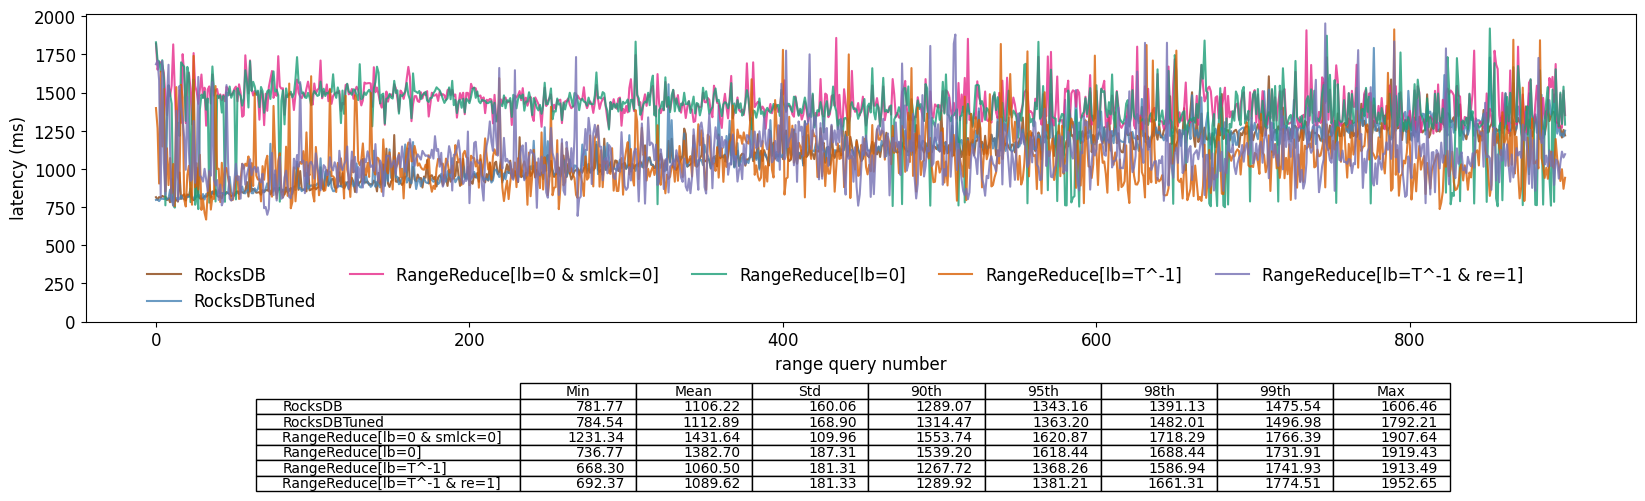

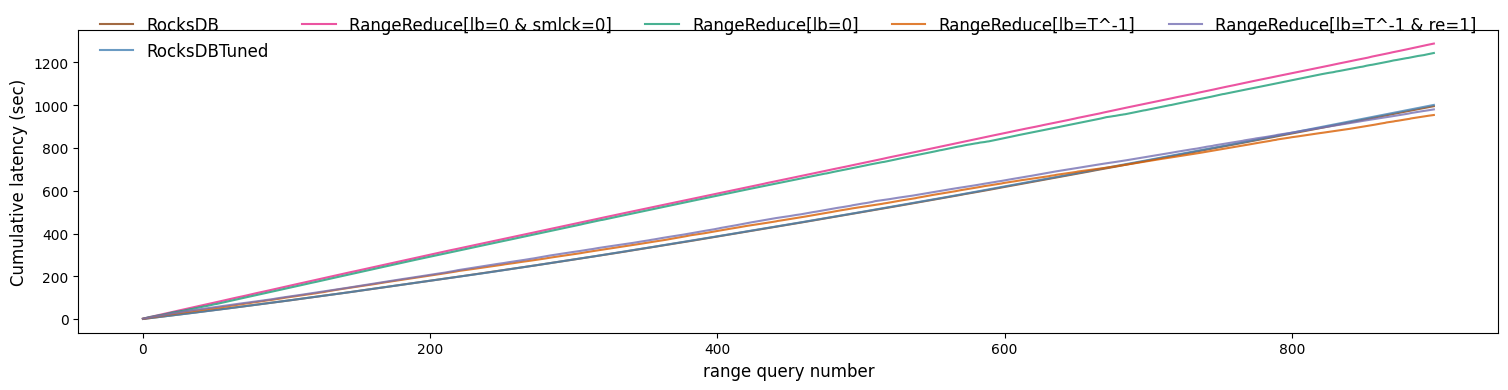

RocksDB 27.824746131896973
RocksDBTuned -0.002503447911136005
RangeReduce[lb=0 & smlck=0] 2.4241894783176066
RangeReduce[lb=0] 2.211008636409854
RangeReduce[lb=T^-1] 0.17231250388781896
RangeReduce[lb=T^-1 & re=1] 0.12532191979235607


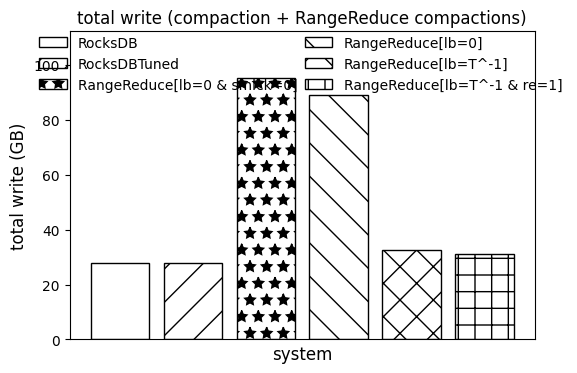

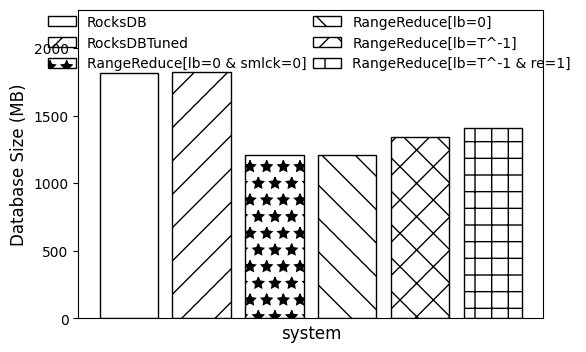

RocksDB 997.2511186599731
RocksDBTuned 0.008450834061678464
RangeReduce[lb=0 & smlck=0] -0.5500963551012156
RangeReduce[lb=0] -0.5698438375857727
RangeReduce[lb=T^-1] -0.6385265376640024
RangeReduce[lb=T^-1 & re=1] -0.5859383392063479


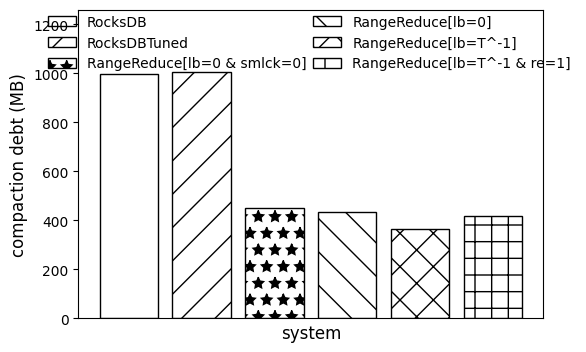

RocksDB 1.776404325850308
RocksDBTuned 0.0025040028043499334
RangeReduce[lb=0 & smlck=0] -0.3350269018550546
RangeReduce[lb=0] -0.3372013933938829
RangeReduce[lb=T^-1] -0.26263383200358587
RangeReduce[lb=T^-1 & re=1] -0.22760329789873315


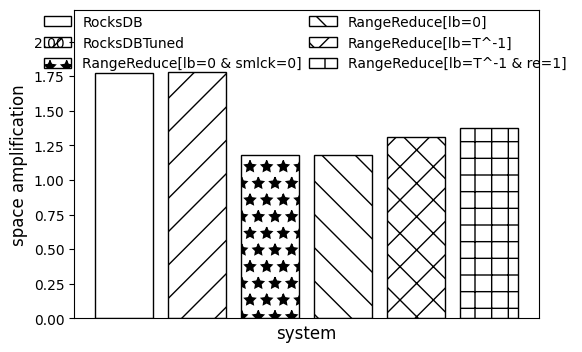

RocksDB 28.634596061892807
RocksDBTuned -0.0025474444394341174
RangeReduce[lb=0 & smlck=0] -0.15009355151093265
RangeReduce[lb=0] -0.14483888287832125
RangeReduce[lb=T^-1] -0.3400342217106016
RangeReduce[lb=T^-1 & re=1] -0.3554716715405485


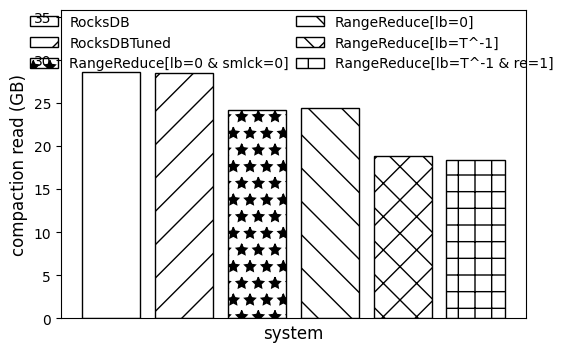

RocksDB 3209.714101635
RocksDBTuned 0.001180952429086772
RangeReduce[lb=0 & smlck=0] 0.08997206182825904
RangeReduce[lb=0] 0.07622222740383401
RangeReduce[lb=T^-1] -0.014145538263334013
RangeReduce[lb=T^-1 & re=1] -0.005831160607579707


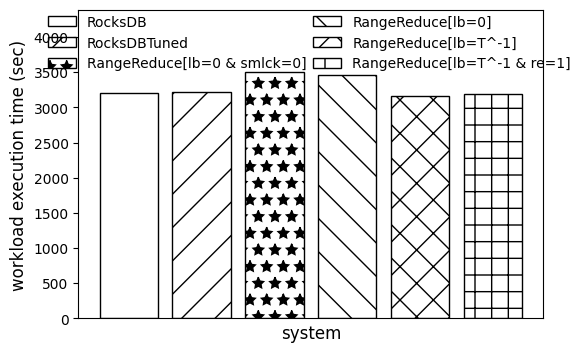

RocksDB 180.5274185659364
RocksDBTuned -0.00038828814096836055
RangeReduce[lb=0 & smlck=0] 0.19062264323627706
RangeReduce[lb=0] 0.15816134970496157
RangeReduce[lb=T^-1] -0.1265089841566042
RangeReduce[lb=T^-1 & re=1] -0.11808048351565777


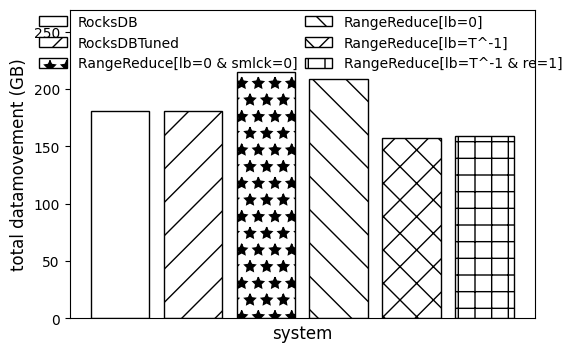

| Method                      | Average Bytes Read RQ (MB)   | RQ Latency (avg ms)   | Total Writes (GB)   | Compaction Debt (MB)   | Space Amplification   | Total Compaction Read (Not RR)   | W/L Execution Time (sec)   | Overall Data Movement (GB)   |
|-----------------------------|------------------------------|-----------------------|---------------------|------------------------|-----------------------|----------------------------------|----------------------------|------------------------------|
| RocksDB                     | 141.16                       | 1106.22               | 27.82               | 997.25                 | 1.78                  | 28.63                            | 3209.71                    | 180.53                       |
| RocksDBTuned                | 0.06%                        | 0.6%                  | -0.25%              | 0.85%                  | 0.25%                 | -0.25%                           | 0.12%                      | -0.04%             

In [3]:
random_rq_stats = dict()
random_rq_stats_for_rq = dict()

lb = 1 / SIZE_RATIO
EXPDIRNAME = f"{PROJECT_DIR}/.vstats/experiments-{TAG}-U{UPDATES}-E{ENTRY_SIZE}-B{ENTRIES_PER_PAGE}-S{RANGE_QUERIES}-Y{SELECTIVITY}-T{SIZE_RATIO}"

rocksdb_dirpath = os.path.join(EXPDIRNAME, "RocksDB")
rocksdb_tuned_dirpath = os.path.join(EXPDIRNAME, "RocksDBTuned")
rr_lb0_smlck0_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=0ANDsmlck=0]")
rr_lb0_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=0]")
rr_lb_1_by_T_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=T^-1]")
rr_lb_1_by_T_and_re_1_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=T^-1ANDre=1]")

filesize = ENTRY_SIZE * ENTRIES_PER_PAGE * NUM_PAGE_PER_FILE

rocksdb = EpochStats(rocksdb_dirpath, NUMEPOCHS, filesize)
rocksdb_tuned = EpochStats(rocksdb_tuned_dirpath, NUMEPOCHS, filesize)
rr_lb_0_smlck_0 = EpochStats(rr_lb0_smlck0_dirpath, NUMEPOCHS, filesize)
rr_lb_0 = EpochStats(rr_lb0_dirpath, NUMEPOCHS, filesize)
rr_lb_1_by_T = EpochStats(rr_lb_1_by_T_dirpath, NUMEPOCHS, filesize)
rr_lb_1_by_T_and_re_1 = EpochStats(rr_lb_1_by_T_and_re_1_dirpath, NUMEPOCHS, filesize)

plot_exp = PlotRangeQueryStats(
    {
        "RocksDB": rocksdb.get_rangequerystats(),
        "RocksDBTuned": rocksdb_tuned.get_rangequerystats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_rangequerystats(),
        "RangeReduce[lb=0]": rr_lb_0.get_rangequerystats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_rangequerystats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_rangequerystats(),
    }
)
plot_exp.bytes_read_for_each_range_query()
plot_exp.latency_for_each_range_query()
plot_exp.cummulative_latency_for_range_queries()

metric_exp = PlotEpochStats(
    {
        "RocksDB": rocksdb.get_plotstats(),
        "RocksDBTuned": rocksdb_tuned.get_plotstats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_plotstats(),
        "RangeReduce[lb=0]": rr_lb_0.get_plotstats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_plotstats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_plotstats(),
    }
)
metric_exp.plot_total_bytes_written()
metric_exp.plot_database_size()
metric_exp.plot_compaction_debt()
metric_exp.plot_space_amplification()
metric_exp.plot_compaction_read()
metric_exp.plot_workload_exec_time()
plot_total_data_movement(
    {
        "RocksDB": rocksdb.get_plotstats(),
        "RocksDBTuned": rocksdb_tuned.get_plotstats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_plotstats(),
        "RangeReduce[lb=0]": rr_lb_0.get_plotstats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_plotstats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_plotstats(),
    },
    {
        "RocksDB": rocksdb.get_rangequerystats(),
        "RocksDBTuned": rocksdb_tuned.get_rangequerystats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_rangequerystats(),
        "RangeReduce[lb=0]": rr_lb_0.get_rangequerystats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_rangequerystats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_rangequerystats(),
    },
)

rows = []
for method, metrics in TABLE_DATA.items():
    row = {"Method": method}
    row.update(metrics)
    rows.append(row)

markdown_table = tabulate(rows, headers="keys", tablefmt="github")
print(markdown_table)